In [0]:
import pandas as pd
import numpy as np
import chess
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
raw_data = pd.read_csv('/content/gdrive/My Drive/cse519_project/dataset.csv')

In [0]:
raw_data['TIME_CONTROL']

0         600+0
1         300+0
2         600+0
3         480+0
4         600+0
5          60+0
6          60+0
7         600+0
8        1800+0
9         600+0
10        180+2
11        300+3
12        120+0
13        600+0
14       900+15
15       900+15
16       900+15
17        900+0
18        180+0
19         60+0
20         60+0
21         60+0
22         30+0
23        180+0
24        720+0
25        120+1
26         60+0
27        300+0
28        600+0
29        600+0
          ...  
11705      30+0
11706     600+5
11707     180+2
11708     180+2
11709      15+0
11710      15+0
11711     600+0
11712      15+0
11713      15+0
11714      60+0
11715      15+0
11716      15+0
11717     300+0
11718      30+0
11719     120+0
11720     300+0
11721      60+1
11722    1500+1
11723     300+3
11724     300+3
11725     240+4
11726      60+3
11727     300+0
11728      15+0
11729     420+0
11730      15+0
11731      15+0
11732     600+0
11733     180+2
11734      60+1
Name: TIME_CONTROL, Leng

# Generate Data

In [10]:
data = raw_data.copy()
data.head(5)

,GAME_TYPE,WHITE_NAME,BLACK_NAME,RESULT,UTC_DATE,UTC_TIME,WHITE_ELO,BLACK_ELO,WHITE_RATING_DIFF,BLACK_RATING_DIFF,ECO,OPENING,TIME_CONTROL,TERMINATION,RECORD
0,Classical,madskillz,Pavvell,1-0,2017.03.31,22:00:02,2207,2311,20,-16,A74,"Benoni Defense: Classical Variation, Full Line",600+0,Normal,1. d4 { [%eval 0.27] [%clk 0:05:00] } 1... Nf6...
1,Blitz,Grooveyard,katastropha,0-1,2017.03.31,22:00:02,1520,1538,-11,10,D00,Queen's Pawn Game: Mason Attack,300+0,Normal,1. d4 { [%eval 0.12] [%clk 0:05:00] } 1... d5 ...
2,Classical,Justlin,Peera,0-1,2017.03.31,22:00:02,1403,1382,-12,14,C42,Russian Game: Three Knights Game,600+0,Normal,1. e4 { [%eval 0.29] [%clk 0:10:00] } 1... e5 ...
3,Classical,pepsi_pepsi,Karamitros,1-0,2017.03.31,22:00:01,2275,2236,11,-9,A46,Indian Game: Polish Variation,480+0,Normal,1. d4 { [%eval 0.22] [%clk 0:08:00] } 1... Nf6...
4,Classical,medo-mega,mohamedelwakel,0-1,2017.03.31,22:00:02,1811,1819,-12,12,D31,Semi-Slav Defense: Accelerated Move Order,600+0,Time forfeit,1. d4 { [%eval 0.14] [%clk 0:10:00] } 1... d5 ...


In [0]:
def Define_Firsthand(record):
  target = "[a-z][0-9]"
  first_location = int(str(re.search(target, record)[0])[1])
  if first_location <= 4 :
    first = 'White'
  else:
    first = 'Black'
  return first

In [0]:
data['FIRST'] = data['RECORD'].apply(lambda x: Define_Firsthand(x))

In [0]:
def generate_eval_list(record, return_white=True):
  target = "eval\s\#?[-+]?\d{1,2}\.?\d{1,2}"
  match_eval = re.findall(target, record)
  white_eval = []
  black_eval = []
  for i in range(len(match_eval)):
    try:
      local_eval = float(match_eval[i][5:].strip('#'))
    except:
      local_eval = float(match_eval[i][5:])
    if i%2 == 0:
      white_eval.append(local_eval)
    else:
      black_eval.append(local_eval)
  if return_white:
    return white_eval
  else:
    return black_eval

In [0]:
data['WHITE_LOCAL_EVAL'] = data['RECORD'].apply(lambda x : generate_eval_list(x,True))
data['BLACK_LOCAL_EVAL'] = data['RECORD'].apply(lambda x : generate_eval_list(x,False))

In [0]:
def generate_clock_list(record, return_white=True):
  target = "\d{1,2}:\d{1,2}:\d{1,2}"
  match_obj = re.findall(target, record)
  white_clock = []
  black_clock = []
  for i in range(len(match_obj)):
    if i%2 == 0:
      white_clock.append(match_obj[i])
    else:
      black_clock.append(match_obj[i])
 
  if return_white:
    return white_clock
  else:
    return black_clock

In [0]:
data['WHITE_CLOCK'] = data['RECORD'].apply(lambda x : generate_clock_list(x,True))
data['BLACK_CLOCK'] = data['RECORD'].apply(lambda x : generate_clock_list(x,False))

In [0]:
def generate_position_list(record):
  match1 = re.findall("\s\{\s\[%eval\s\#?[-+]?[0-9]*\.?[0-9]+\]\s\[%clk\s\d{1,2}:\d{1,2}:\d{1,2}\]\s\}",record)
  match2 = re.findall("\d{2}\.",record)
  match3 = re.findall("\d\.",record)
  match = match1 + match2 + match3

  for m in match:
    record = record.replace(m,'')
  record = record.replace('..','').split(' ')
  record = [elmt for elmt in record if elmt != '' and elmt[0].isalpha()]
  return record

In [0]:
data['TRANSCRIPT'] = data['RECORD'].apply(lambda x : generate_position_list(x))

In [0]:
def generate_final_location(transcript, return_matrix=False):
  board = chess.Board()
  for elmt in transcript:
    try:
      elmt = elmt.strip('?!')
    except:
      pass
    board.push_san(elmt)
  if return_matrix:
    board_matrix = np.asarray(str(board).replace('\n',' ').split(' ')).reshape(8,8)
    return board_matrix
  else:
    return board


In [0]:
data['FINAL_POSITION'] = data['TRANSCRIPT'].apply(lambda x : generate_final_location(x))

In [0]:
data['FINAL_POSITION_MATRIX'] = data['TRANSCRIPT'].apply(lambda x : generate_final_location(x,True))

In [22]:
data.columns

Index(['GAME_TYPE', 'WHITE_NAME', 'BLACK_NAME', 'RESULT', 'UTC_DATE',
       'UTC_TIME', 'WHITE_ELO', 'BLACK_ELO', 'WHITE_RATING_DIFF',
       'BLACK_RATING_DIFF', 'ECO', 'OPENING', 'TIME_CONTROL', 'TERMINATION',
       'RECORD', 'FIRST', 'WHITE_LOCAL_EVAL', 'BLACK_LOCAL_EVAL',
       'WHITE_CLOCK', 'BLACK_CLOCK', 'TRANSCRIPT', 'FINAL_POSITION',
       'FINAL_POSITION_MATRIX'],
      dtype='object')

# Analysis

## Rating prediction from game transcript 

In [0]:
data_analysis_1 = data.copy()

In [0]:
white_elo = data_analysis_1['WHITE_ELO']
white_local_eval = data_analysis_1['WHITE_LOCAL_EVAL']
black_elo = data_analysis_1['BLACK_ELO']
black_local_eval = data_analysis_1['BLACK_LOCAL_EVAL']
elo = white_elo + black_elo
local_eval = white_local_eval + black_local_eval

In [0]:
Question1 = pd.DataFrame({'ELO':elo, 'LOCAL_EVAL':local_eval})

In [0]:
Question1['LOCAL_EVAL_MEAN'] = Question1['LOCAL_EVAL'].apply(lambda x : np.mean(x))

In [0]:
Question1['LOCAL_EVAL_STD'] = Question1['LOCAL_EVAL'].apply(lambda x : np.std(x))

In [0]:
Question1['LOCAL_EVAL_MIN'] = Question1['LOCAL_EVAL'].apply(lambda x : np.min(x))

In [0]:
Question1['LOCAL_EVAL_MAX'] = Question1['LOCAL_EVAL'].apply(lambda x : np.max(x))

In [0]:
def plot_elo_class(type_):
  for i in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'):
    sns.scatterplot(Question1[Question1['ELO_CLASS']==i][type_], Question1[Question1['ELO_CLASS']==i]['ELO'], label=i, s=5)

In [0]:
Question1.loc[Question1['ELO']>5000,'ELO_CLASS'] = 'A'
Question1.loc[Question1['ELO']<5000,'ELO_CLASS'] = 'B'
Question1.loc[Question1['ELO']<4500,'ELO_CLASS'] = 'C'
Question1.loc[Question1['ELO']<4000,'ELO_CLASS'] = 'D'
Question1.loc[Question1['ELO']<3500,'ELO_CLASS'] = 'E'
Question1.loc[Question1['ELO']<3000,'ELO_CLASS'] = 'F'
Question1.loc[Question1['ELO']<2500,'ELO_CLASS'] = 'G'
Question1.loc[Question1['ELO']<2000,'ELO_CLASS'] = 'H'


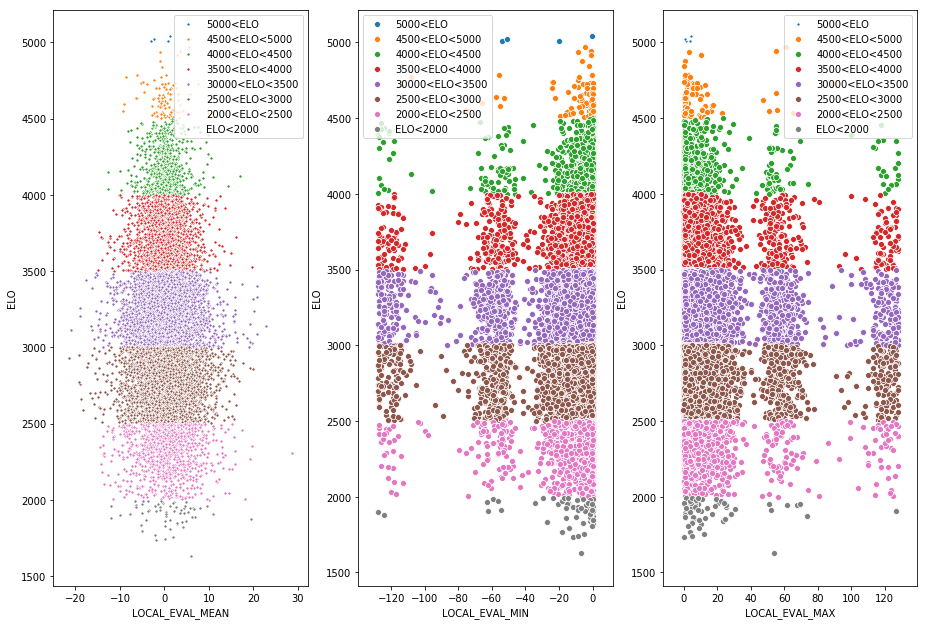

In [32]:
plt.subplot(131)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='A']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='A']['ELO'], label='5000<ELO', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='B']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='B']['ELO'], label='4500<ELO<5000', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='C']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='C']['ELO'], label='4000<ELO<4500', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='D']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='D']['ELO'], label='3500<ELO<4000', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='E']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='E']['ELO'], label='30000<ELO<3500', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='F']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='F']['ELO'], label='2500<ELO<3000', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='G']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='G']['ELO'], label='2000<ELO<2500', s=5)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='H']['LOCAL_EVAL_MEAN'], Question1[Question1['ELO_CLASS']=='H']['ELO'], label='ELO<2000', s=10)
plt.subplot(132)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='A']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='A']['ELO'], label='5000<ELO')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='B']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='B']['ELO'], label='4500<ELO<5000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='C']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='C']['ELO'], label='4000<ELO<4500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='D']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='D']['ELO'], label='3500<ELO<4000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='E']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='E']['ELO'], label='30000<ELO<3500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='F']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='F']['ELO'], label='2500<ELO<3000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='G']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='G']['ELO'], label='2000<ELO<2500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='H']['LOCAL_EVAL_MIN'], Question1[Question1['ELO_CLASS']=='H']['ELO'], label='ELO<2000')
plt.subplot(133)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='A']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='A']['ELO'], label='5000<ELO', s=10)
sns.scatterplot(Question1[Question1['ELO_CLASS']=='B']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='B']['ELO'], label='4500<ELO<5000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='C']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='C']['ELO'], label='4000<ELO<4500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='D']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='D']['ELO'], label='3500<ELO<4000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='E']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='E']['ELO'], label='30000<ELO<3500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='F']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='F']['ELO'], label='2500<ELO<3000')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='G']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='G']['ELO'], label='2000<ELO<2500')
sns.scatterplot(Question1[Question1['ELO_CLASS']=='H']['LOCAL_EVAL_MAX'], Question1[Question1['ELO_CLASS']=='H']['ELO'], label='ELO<2000')

plt.subplots_adjust(left=0,right=2,bottom=0,top=2,hspace=0.2,wspace=0.2)

## Game type prediction from transcript

In [0]:
Question2 = data[['GAME_TYPE','WHITE_CLOCK']].copy()

In [0]:
Question2

,GAME_TYPE,WHITE_CLOCK
0,Classical,"[0:05:00, 0:04:59, 0:04:58, 0:04:56, 0:04:55, ..."
1,Blitz,"[0:05:00, 0:04:58, 0:04:57, 0:04:53, 0:04:51, ..."
2,Classical,"[0:10:00, 0:09:56, 0:09:50, 0:09:20, 0:09:16, ..."
3,Classical,"[0:08:00, 0:07:58, 0:07:56, 0:07:56, 0:07:56, ..."
4,Classical,"[0:10:00, 0:09:58, 0:09:56, 0:09:53, 0:09:50, ..."
5,Bullet,"[0:01:00, 0:01:00, 0:00:59, 0:00:59, 0:00:57, ..."
6,Bullet,"[0:01:00, 0:00:59, 0:00:59, 0:00:58, 0:00:57, ..."
7,Classical,"[0:10:00, 0:09:58, 0:09:55, 0:09:50, 0:09:43, ..."
8,Classical,"[0:30:00, 0:29:46, 0:29:29, 0:29:09, 0:28:49, ..."
9,Classical,"[0:10:00, 0:09:48, 0:09:47, 0:09:46, 0:09:42, ..."


## Subtranscript-level analysis

## Computer vs. human?

## Characterizing upsets in chess